In [1]:
import xarray as xr 
import pandas as pd 
import numpy as np
import s3fs
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
from datetime import datetime, timezone
from loguru import logger

In [2]:
after_bucket = "ooi-data/"
before_bucket = "ooi-data-vault/"
fs = s3fs.S3FileSystem(anon=True)

In [3]:
def load_data(stream_name, bucket):
    zarr_dir = bucket + stream_name
    zarr_store = fs.get_mapper(zarr_dir)
    ds = xr.open_zarr(zarr_store, consolidated=True)
    return ds[["pco2_seawater", "pco2w_thermistor_temperature"]]

In [4]:
stream_list = [ 
    "CE02SHBP-LJ01D-09-PCO2WB103-streamed-pco2w_b_sami_data_record",
    "CE04OSBP-LJ01C-09-PCO2WB104-streamed-pco2w_b_sami_data_record",
    "CE04OSPS-PC01B-4D-PCO2WA105-streamed-pco2w_a_sami_data_record",
    "CE04OSPS-SF01B-4F-PCO2WA102-streamed-pco2w_a_sami_data_record",
    "RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record",
    "RS03AXPS-SF03A-4F-PCO2WA301-streamed-pco2w_a_sami_data_record",
]

In [5]:
def ticks(plt):
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())           # tick every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # e.g., "Jan 2024"
    plt.xticks(rotation=45)  # rotate for readability
    plt.tight_layout()
    # --- Add faint vertical lines at each month ---
    plt.grid(axis='x', linestyle='--', color='gray', alpha=0.5, linewidth=0.8)


In [6]:
def stream_summary(stream_name):
    print(f"loading {stream_name}")
    before = load_data(stream_name, before_bucket)
    after = load_data(stream_name, after_bucket)

    plt.figure(figsize=(40, 8))
    plt.ylim(0, 4000)
    plt.title("before and after correction")
    plt.scatter(before['pco2_seawater']['time'], before['pco2_seawater'], s=0.1, color='blue', label='before correction')
    plt.scatter(after['pco2_seawater']['time'], after['pco2_seawater'], s=0.1, color='orange', label='after correction')
    plt.legend(markerscale=50) 
    ticks(plt)
    plt.show()

    temperature = before['pco2w_thermistor_temperature']
    vmin, vmax = np.nanpercentile(temperature, [5, 95])
    plt.figure(figsize=(40, 8))
    plt.title("temperature reading")
    plt.ylim(0, 4000)
    plt.scatter(before['pco2_seawater']['time'], before['pco2_seawater'], s=0.1, c=temperature, cmap='coolwarm', norm=Normalize(vmin=vmin, vmax=vmax))
    ticks(plt)
    plt.show()


    common_times = np.intersect1d(before.time.values, after.time.values)

    before_sub = before.sel(time=common_times)
    after_sub = after.sel(time=common_times)

    years = before_sub['time.year']
    plt.ylim(0, 5000)
    plt.xlim(0, 5000)
    sc = plt.scatter(before_sub['pco2_seawater'], after_sub['pco2_seawater'], s=0.1, c=years, cmap='rainbow')
    plt.xlabel(f"{before_sub['pco2_seawater'].units} before correction")
    plt.ylabel(f"{after_sub['pco2_seawater'].units}after correction")
    cb = plt.colorbar(sc)
    cb.set_label('time')
    plt.show()

    temperature = before_sub['pco2w_thermistor_temperature']

    # compute 5th and 95th percentiles (ignoring nans)
    vmin, vmax = np.nanpercentile(temperature, [5, 95])
    
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(
        before_sub['pco2_seawater'],
        after_sub['pco2_seawater'],
        s=0.1,
        c=temperature,
        cmap='coolwarm',
        norm=Normalize(vmin=vmin, vmax=vmax),
    )
    plt.xlim(0, 5000)
    plt.ylim(0, 5000)
    plt.xlabel(f"{before_sub['pco2_seawater'].units} before correction")
    plt.ylabel(f"{after_sub['pco2_seawater'].units} after correction")
    cb = plt.colorbar(sc)
    cb.set_label('Temperature (°C)')
    plt.show()

    return before_sub, after_sub

In [7]:
res_dict = {}
for stream in stream_list:
    before, after = stream_summary(stream)
    res_dict[stream] = (before, after)

loading CE02SHBP-LJ01D-09-PCO2WB103-streamed-pco2w_b_sami_data_record


ValueError: unrecognized engine 'zarr' must be one of your download engines: ['store']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

# individual profiles

In [196]:
def load_regridding_inputs(refdes, append=True):
    
    now = datetime.now(timezone.utc)
    current_year = now.year
    if append:
        years = current_year
    else:
        years = list(range(START_YEAR, current_year + 1))
    
    site = refdes[:8]
    stream_name = SITES_DICT[refdes]['zarrFile']
    
    logger.info("loading profile indices")
    profile_indices_list = []
    for year in years:
        profile_indices = pd.read_csv(
            f"https://raw.githubusercontent.com/OOI-CabledArray/profileIndices/refs/heads/main/{site}_profiles_{year}.csv"
        )
        profile_indices_list.append(profile_indices)

        all_indices = pd.concat(profile_indices_list, axis=0, ignore_index=True)


    return all_indices

In [197]:
START_YEAR = 2023
SITES_DICT = (
    pd.read_csv("https://raw.githubusercontent.com/OOI-CabledArray/rca-data-tools/refs/heads/main/rca_data_tools/qaqc/params/sitesDictionary.csv")
    .set_index('refDes')
    .T.to_dict('series')
)

VARIABLE_MAP = (
    pd.read_csv("https://raw.githubusercontent.com/OOI-CabledArray/rca-data-tools/refs/heads/main/rca_data_tools/qaqc/params/variableMap.csv")
    .set_index('parameter')
    .T.to_dict('series')
)

In [229]:
indices_301 = load_regridding_inputs('RS03AXPS-SF03A-4F-PCO2WA301', append=False)
indices_101 = load_regridding_inputs('RS01SBPS-SF01A-4F-PCO2WA101', append=False)
indices_102 = load_regridding_inputs('CE04OSPS-SF01B-4F-PCO2WA102', append=False)

2025-10-22 11:36:37.487 | INFO     | __main__:load_regridding_inputs:13 - loading profile indices
2025-10-22 11:36:38.238 | INFO     | __main__:load_regridding_inputs:13 - loading profile indices
2025-10-22 11:36:38.924 | INFO     | __main__:load_regridding_inputs:13 - loading profile indices


In [199]:
indices_301.head()

,profile,start,peak,end
0,16493,2023-08-28 17:44:00,2023-08-28 18:51:00,2023-08-28 19:28:00
1,16494,2023-08-29 01:25:00,2023-08-29 03:41:00,2023-08-29 04:04:00
2,16495,2023-08-29 05:10:00,2023-08-29 06:19:00,2023-08-29 06:54:00
3,16496,2023-08-29 07:41:00,2023-08-29 08:49:00,2023-08-29 10:24:00
4,16497,2023-08-29 11:31:00,2023-08-29 12:37:00,2023-08-29 13:11:00


In [202]:
res_dict["RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record"] # before is 0, after is 1 index

(<xarray.Dataset> Size: 2MB
 Dimensions:                       (time: 65665)
 Coordinates:
   * time                          (time) datetime64[ns] 525kB 2014-10-07T01:0...
 Data variables:
     pco2_seawater                 (time) float64 525kB dask.array<chunksize=(65665,), meta=np.ndarray>
     pco2w_thermistor_temperature  (time) float64 525kB dask.array<chunksize=(65665,), meta=np.ndarray>
 Attributes: (12/62)
     AssetManagementRecordLastModified:  2025-09-03T15:19:25.444000
     AssetUniqueID:                      ATAPL-58336-00003
     Conventions:                        CF-1.6
     Description:                        pCO2 Water: PCO2W Series A
     FirmwareVersion:                    Not specified.
     Manufacturer:                       Sunburst Sensors
     ...                                 ...
     stream:                             pco2w_a_sami_data_record
     subsite:                            RS01SBPS
     summary:                            Dataset Generated by S

In [225]:
def plot_profiles(indices, ds_tuple, tp=100):
    for idx, row in indices.head(tp).iterrows():
    
        before_downcast = ds_tuple[0].sel(time=slice(row['peak'], row['end']))
        after_downcast = ds_tuple[1].sel(time=slice(row['peak'], row['end']))

        if len(before_downcast.time) > 0:

            plt.figure(figsize=(8, 8))
            plt.scatter(
                before_downcast['pco2w_thermistor_temperature'],
                before_downcast['pco2_seawater'],
                label='before',
                color='blue',
                )
            plt.scatter(
                after_downcast['pco2w_thermistor_temperature'],
                after_downcast['pco2_seawater'],
                label='after',
                color='red', 
                )
    
            plt.legend() 
            
    
            plt.ylabel(f"{before_downcast['pco2_seawater'].units}")
            plt.xlabel(f"{before_downcast['pco2w_thermistor_temperature'].units}")
            plt.show()

        

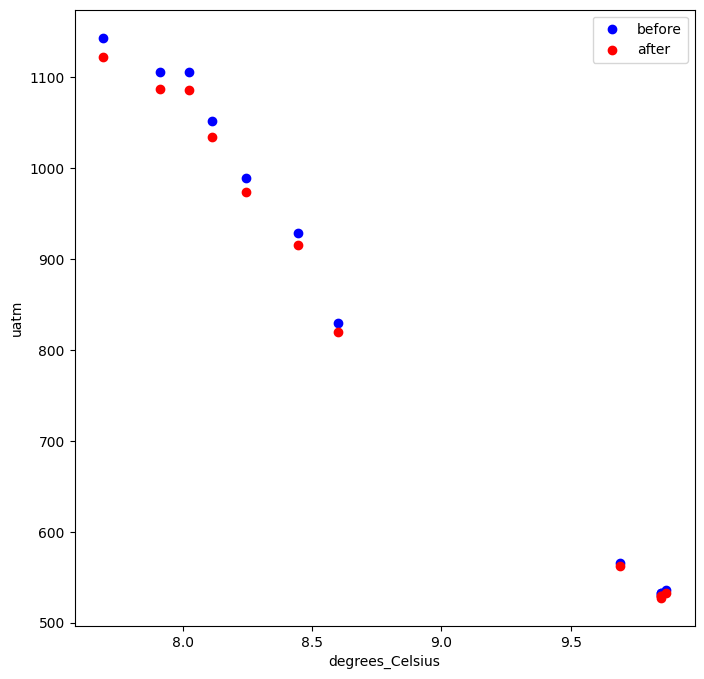

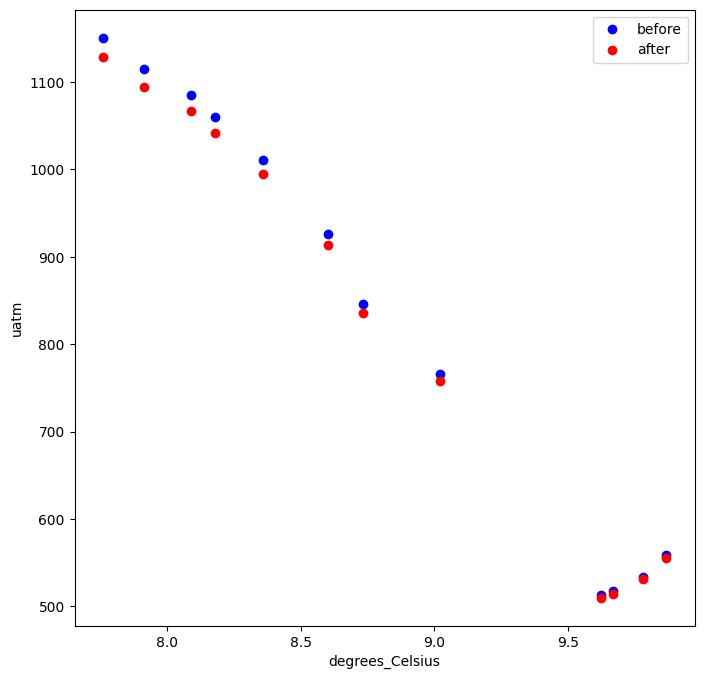

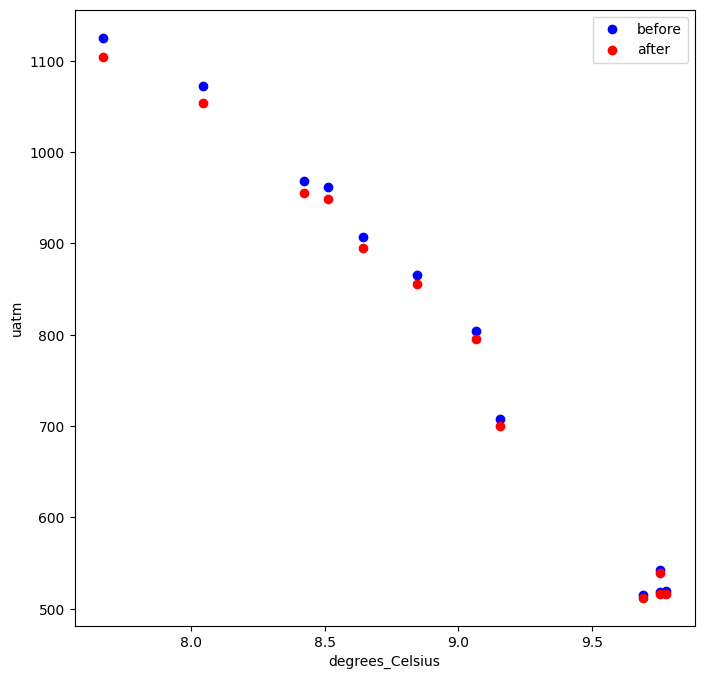

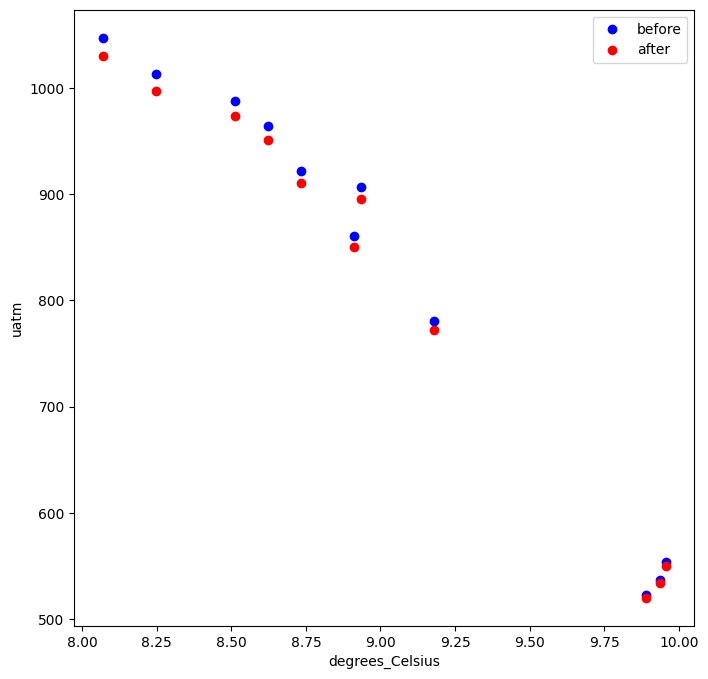

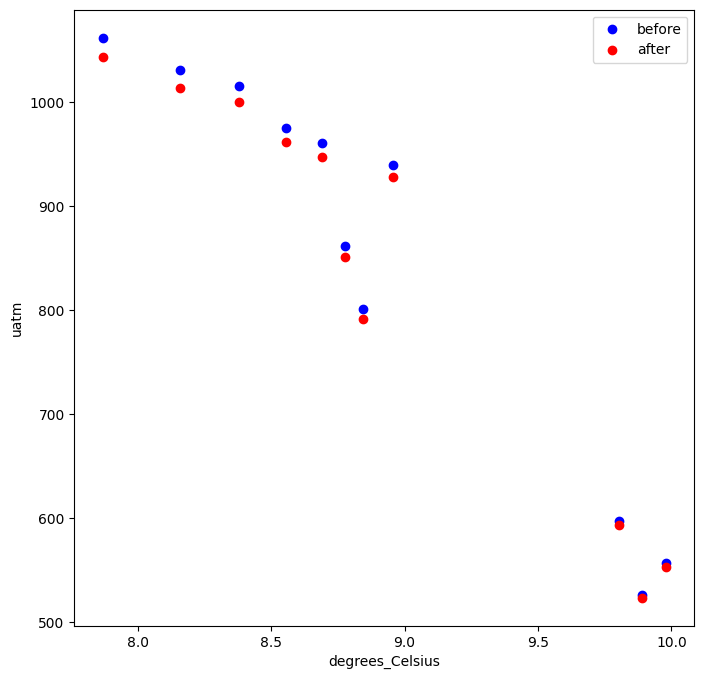

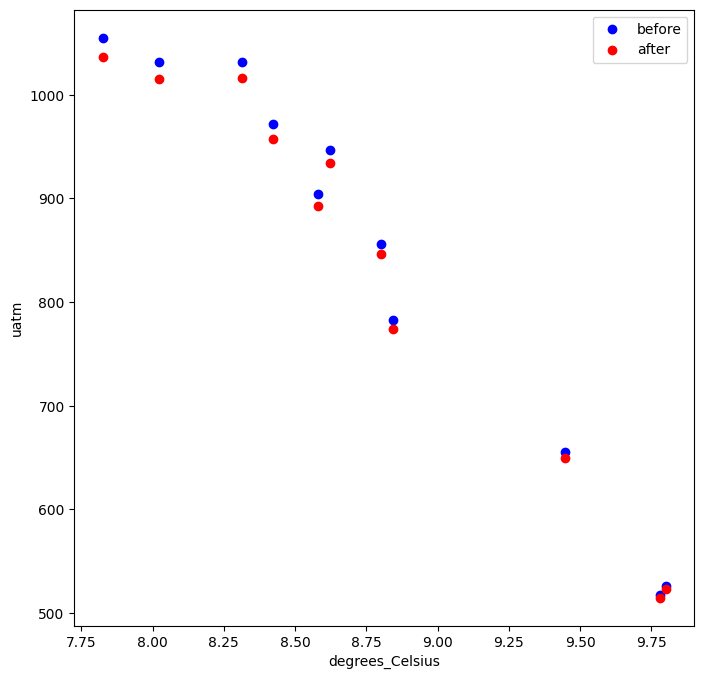

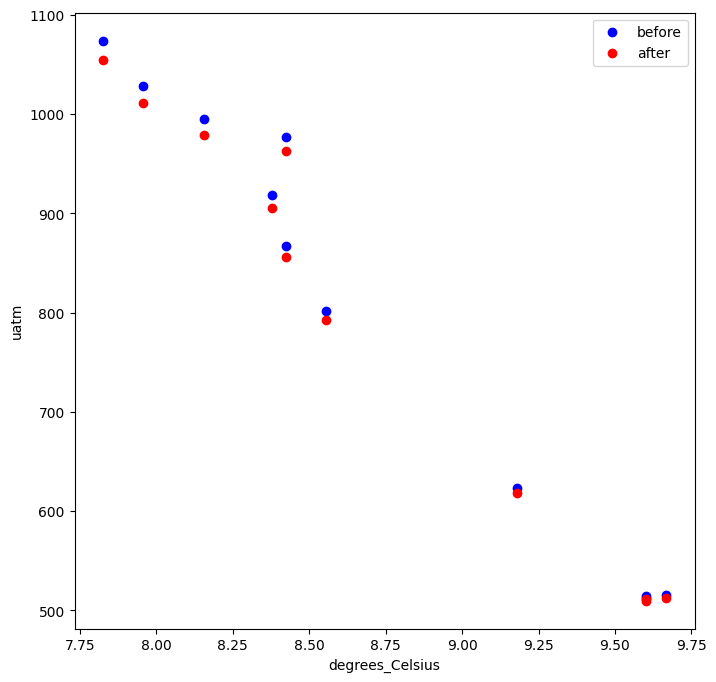

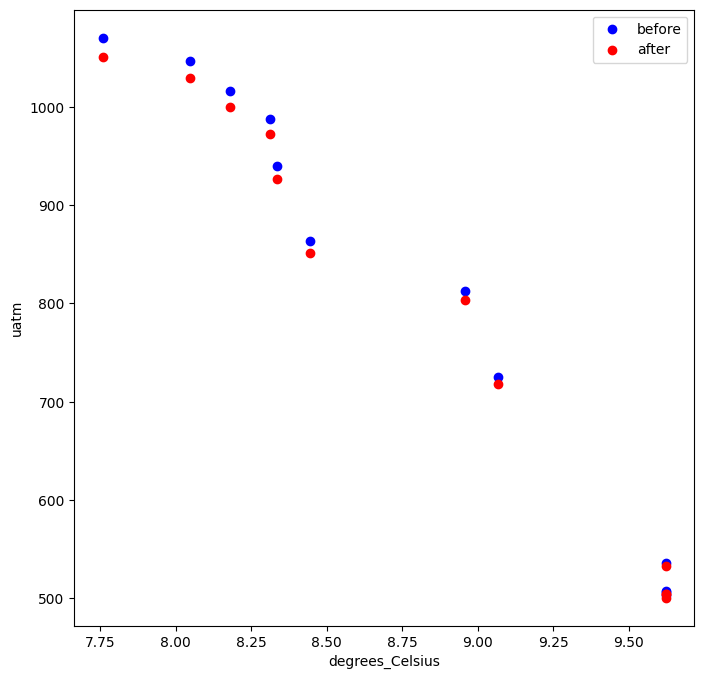

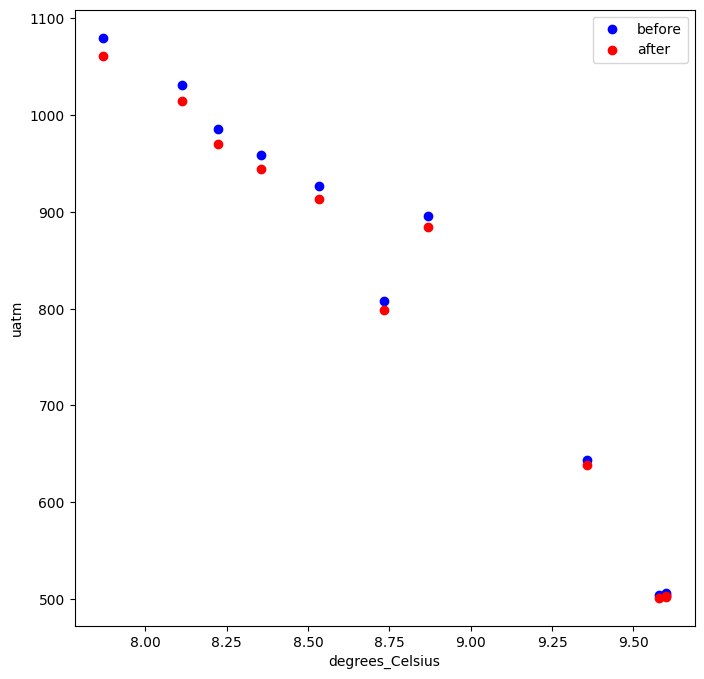

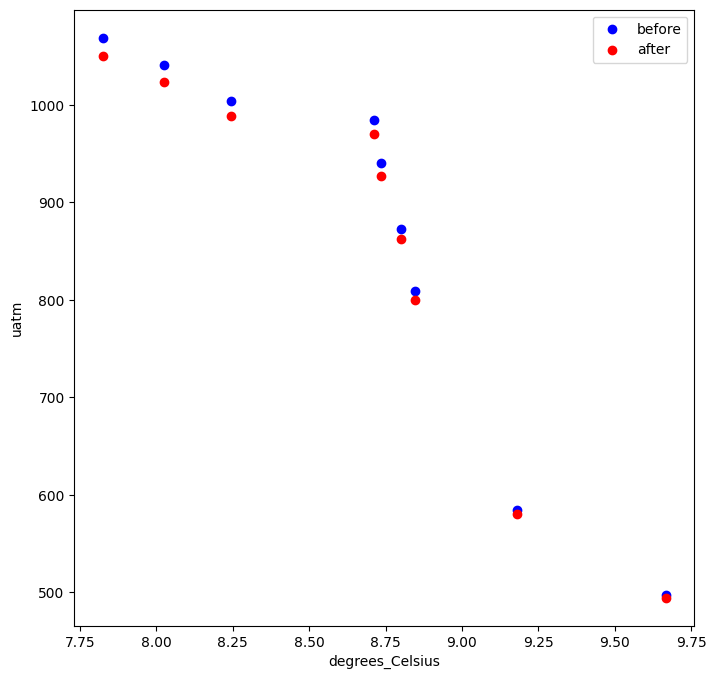

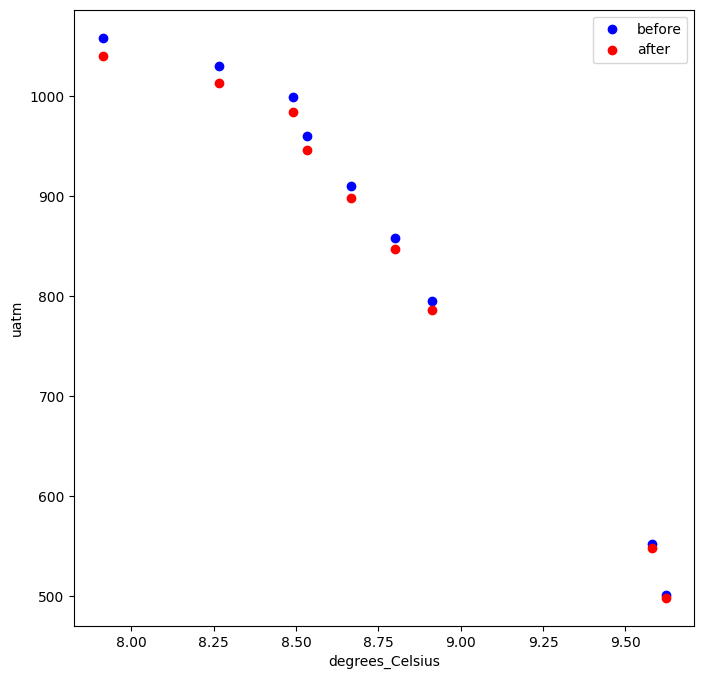

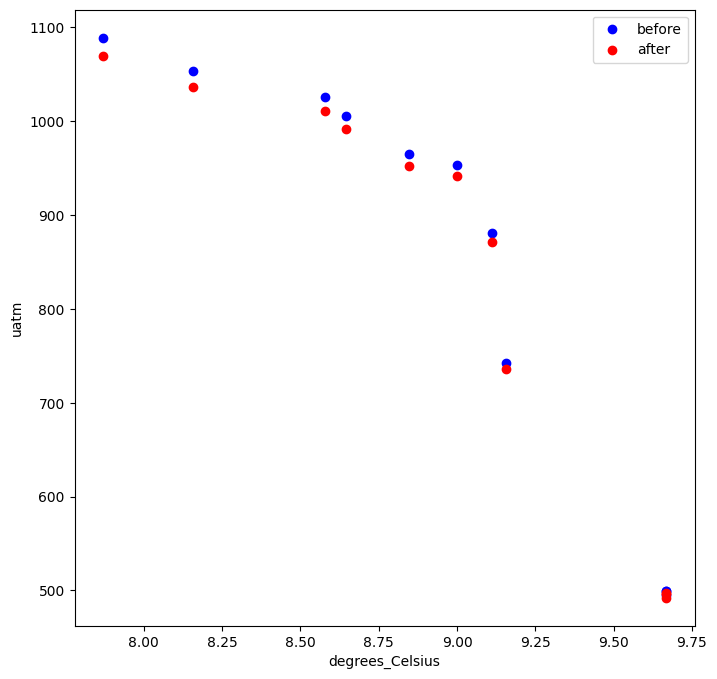

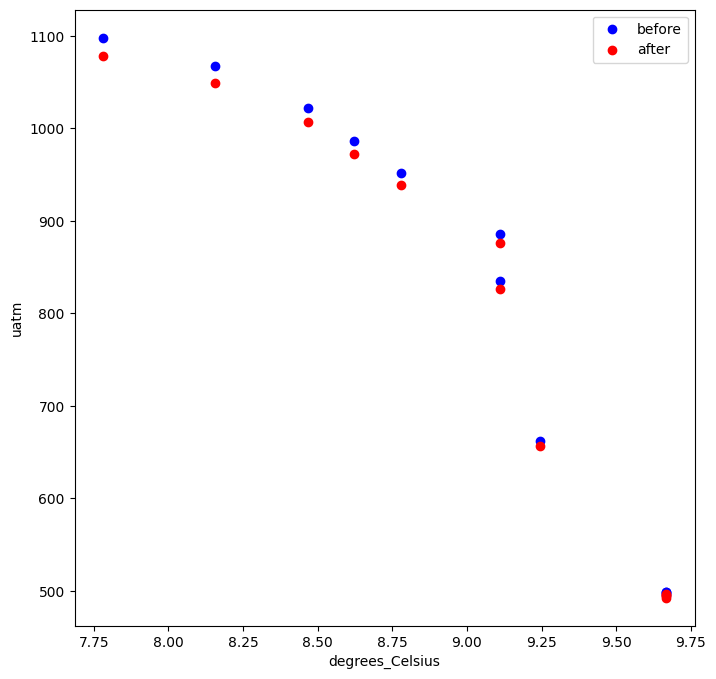

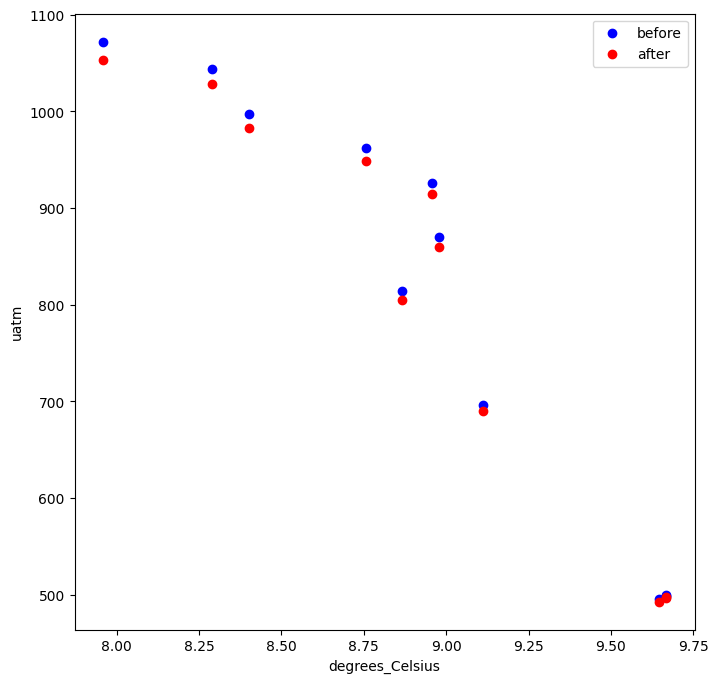

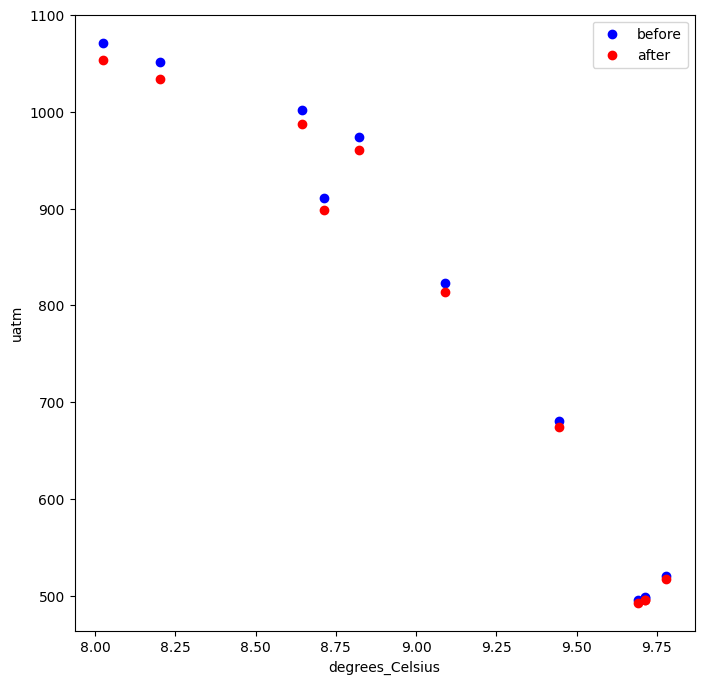

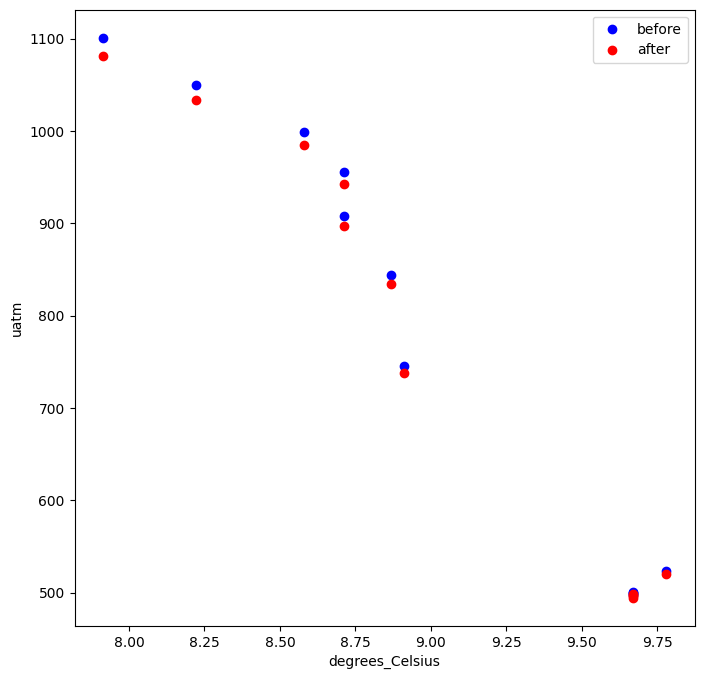

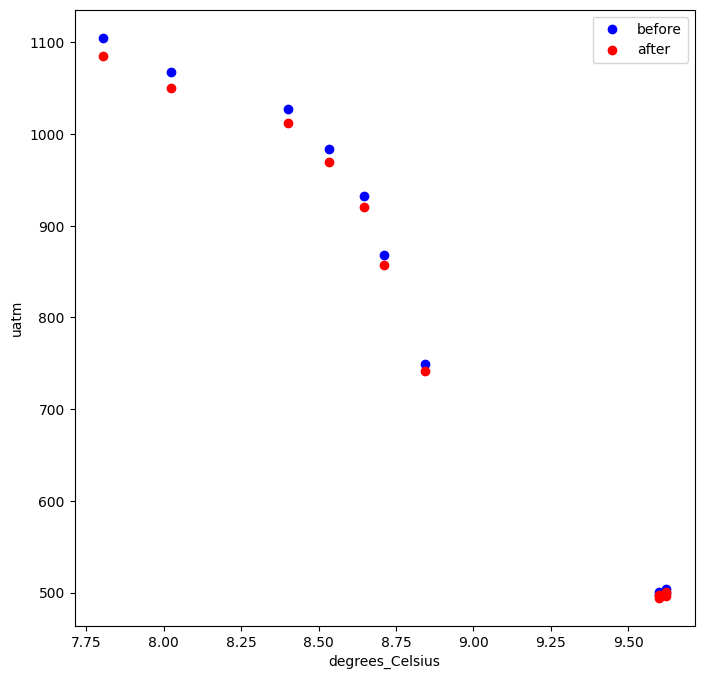

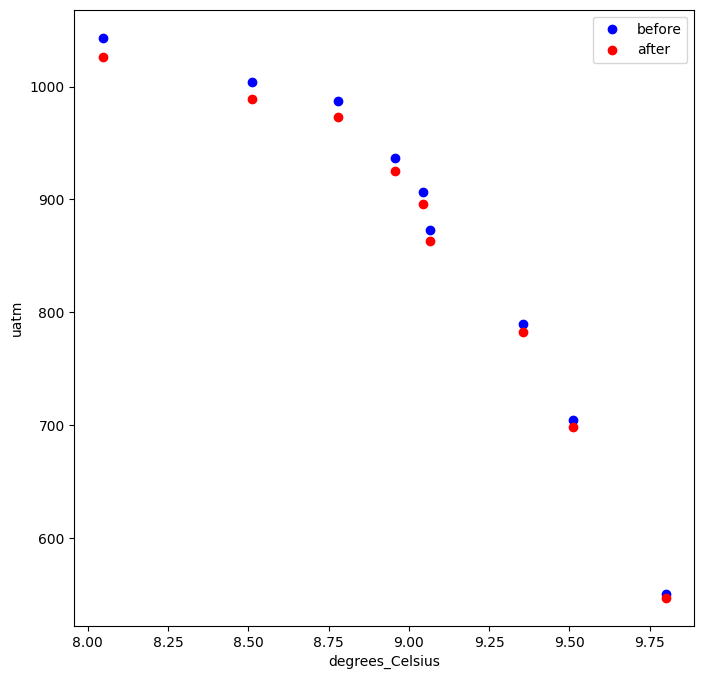

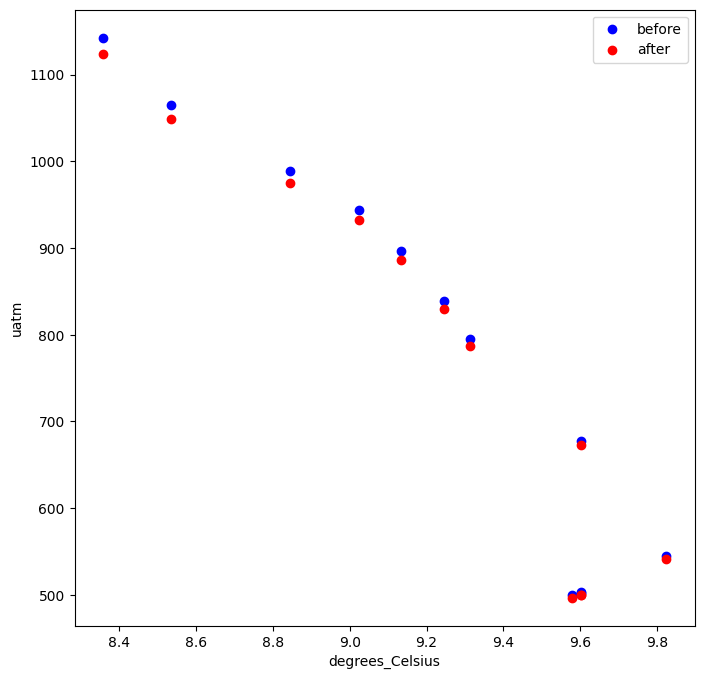

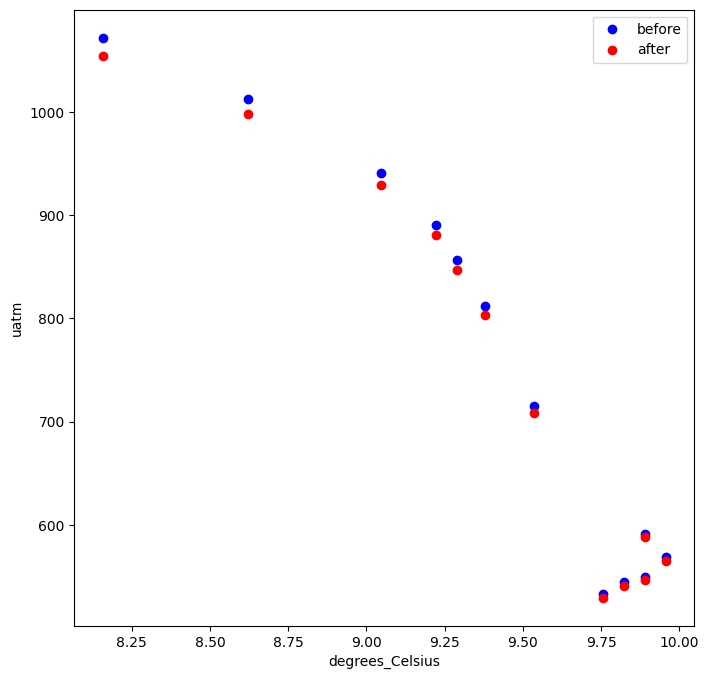

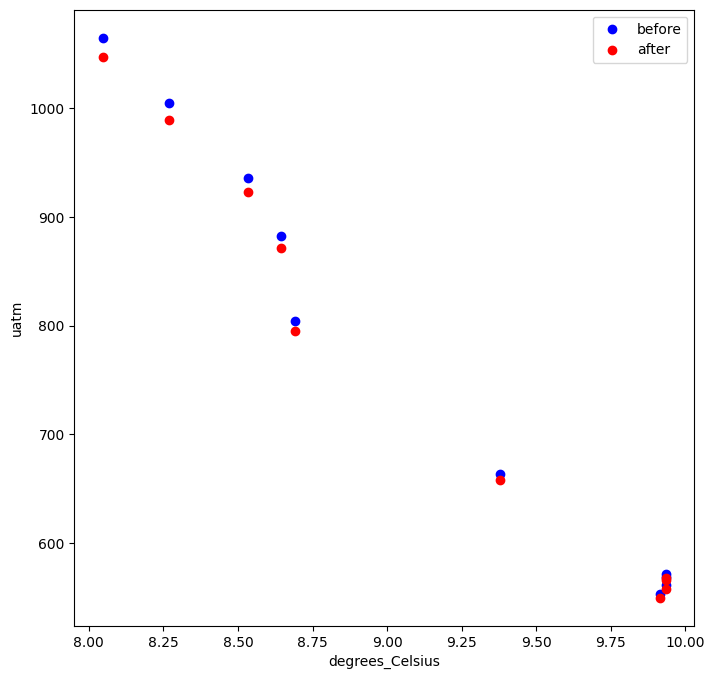

In [226]:
plot_profiles(indices_101, res_dict["RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record"])

In [227]:
plot_profiles(indices_301, res_dict["RS03AXPS-SF03A-4F-PCO2WA301-streamed-pco2w_a_sami_data_record"])

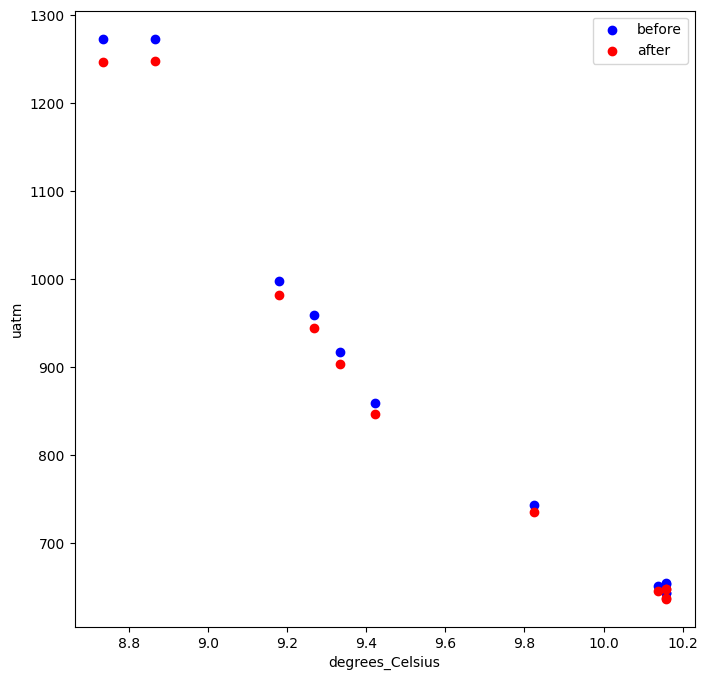

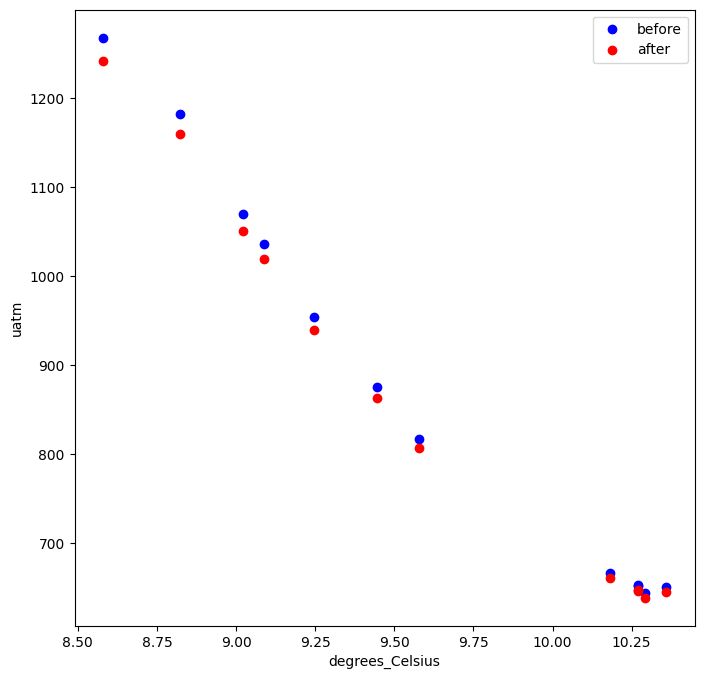

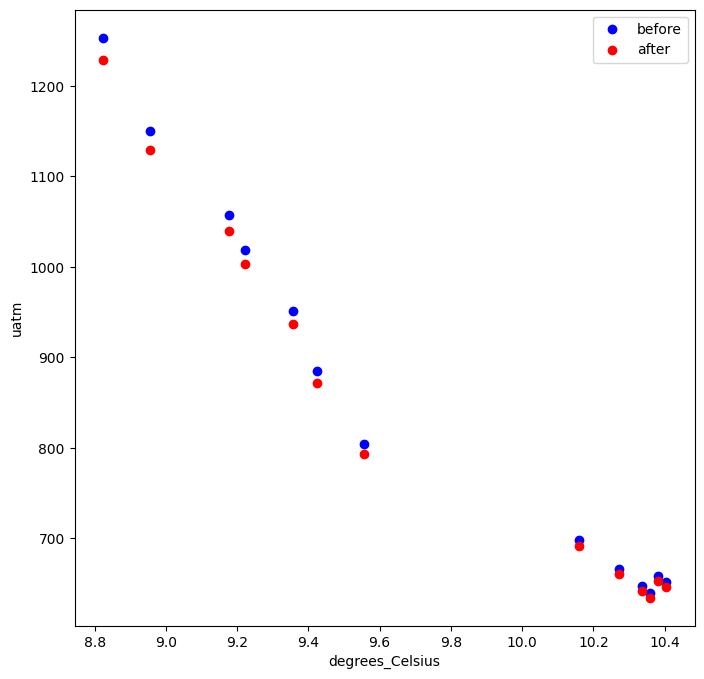

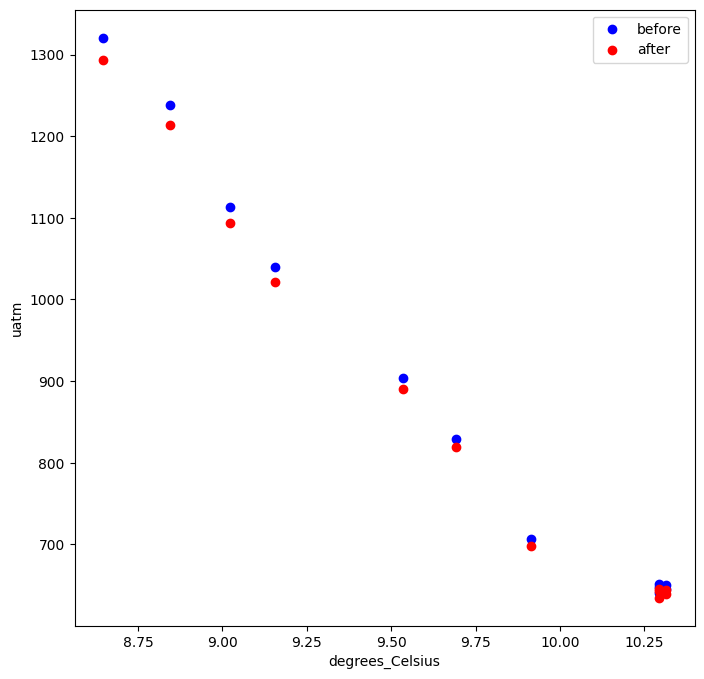

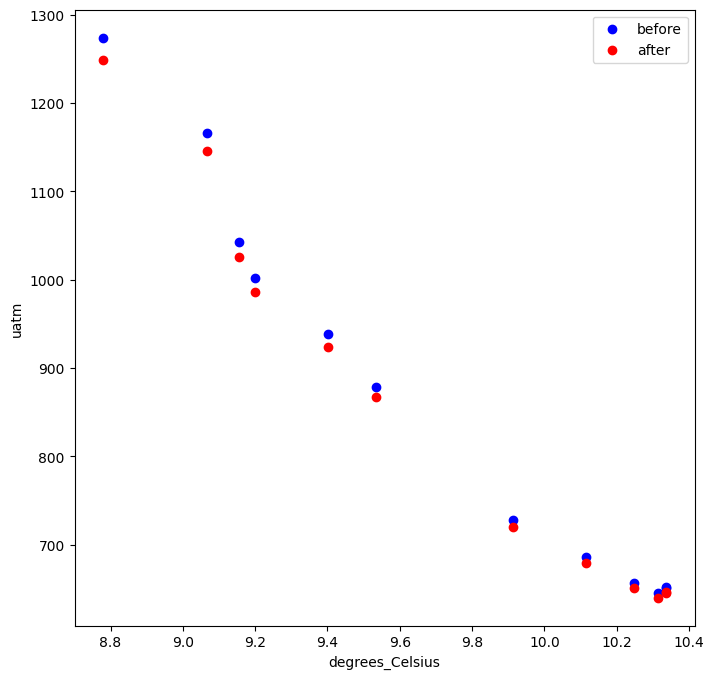

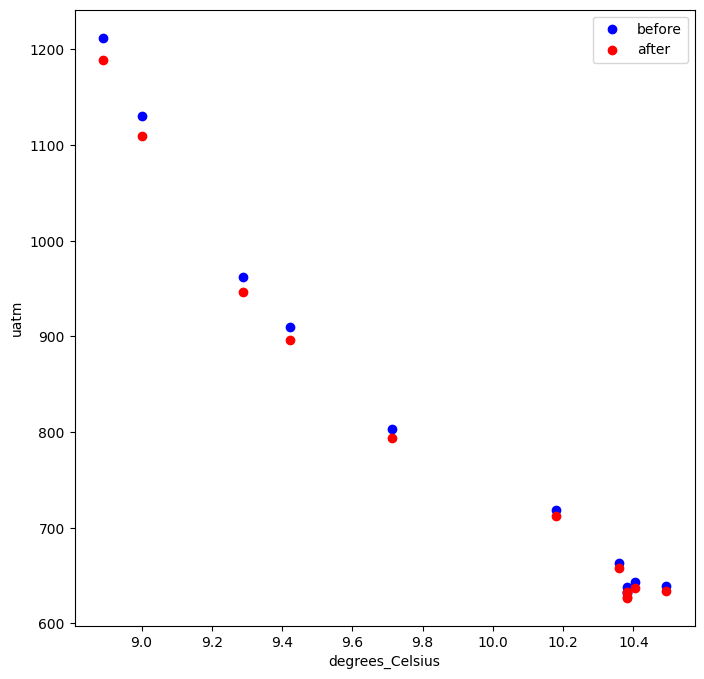

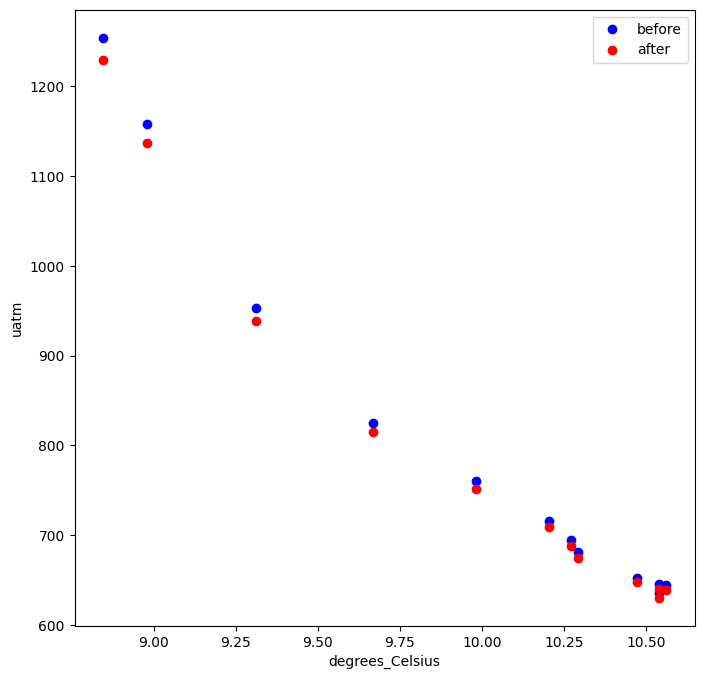

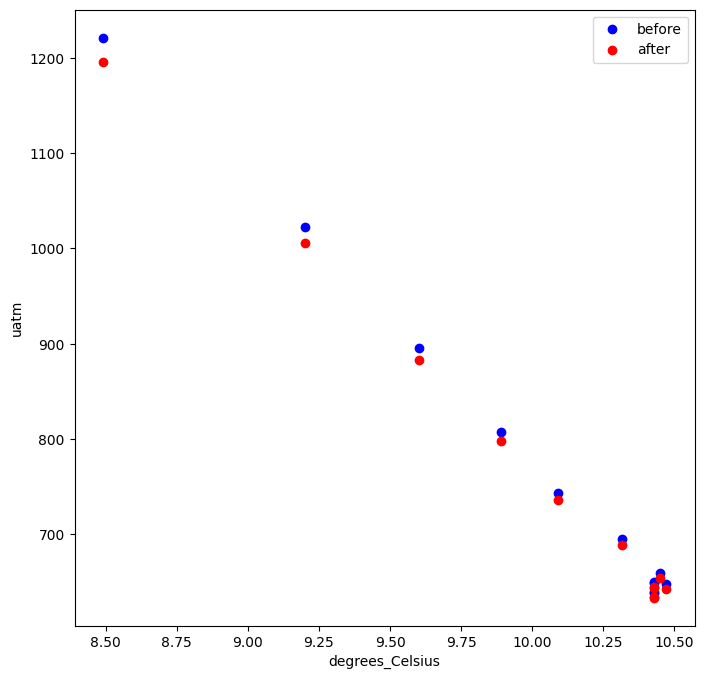

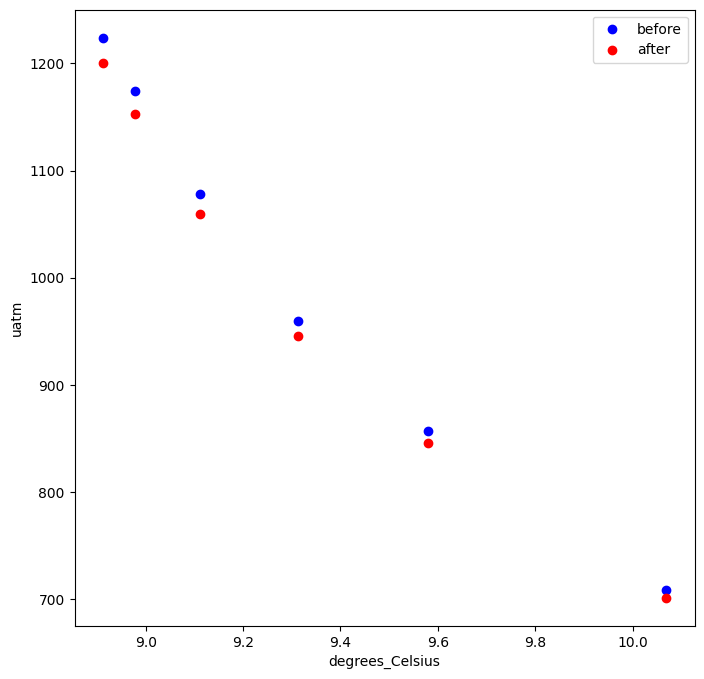

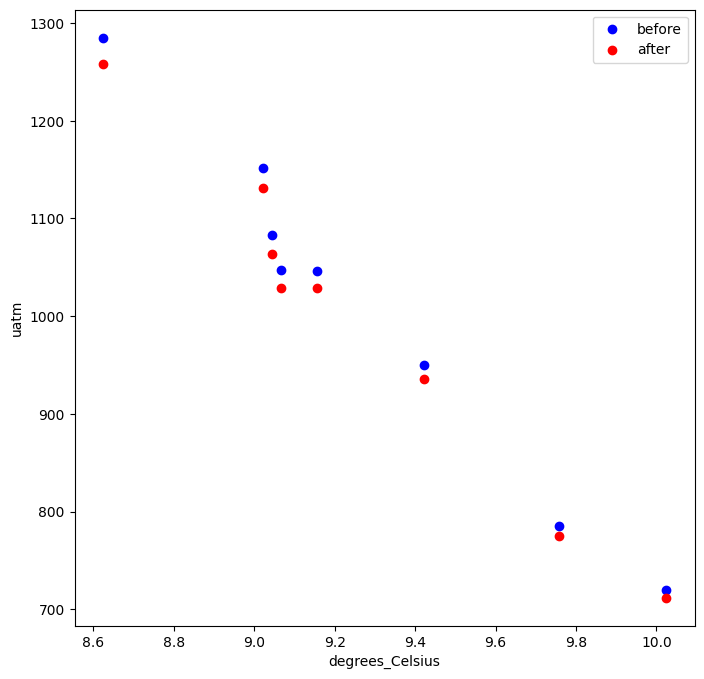

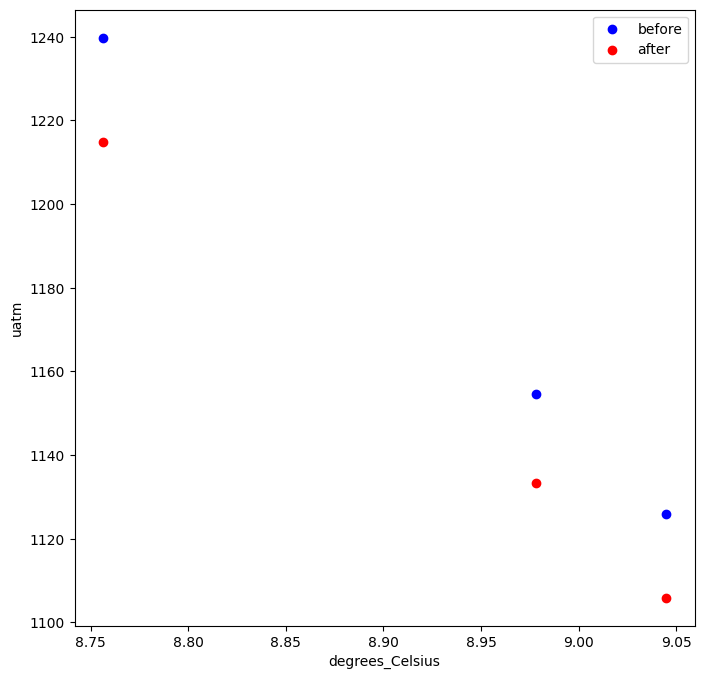

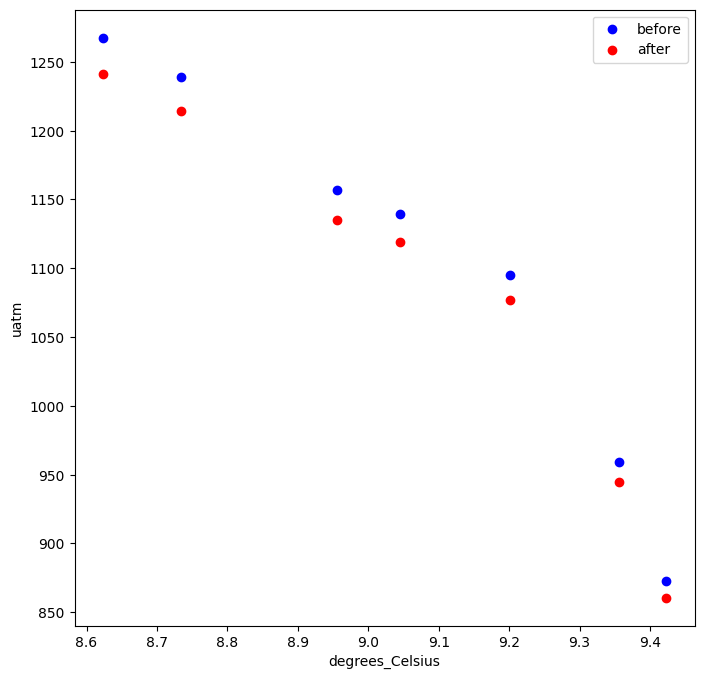

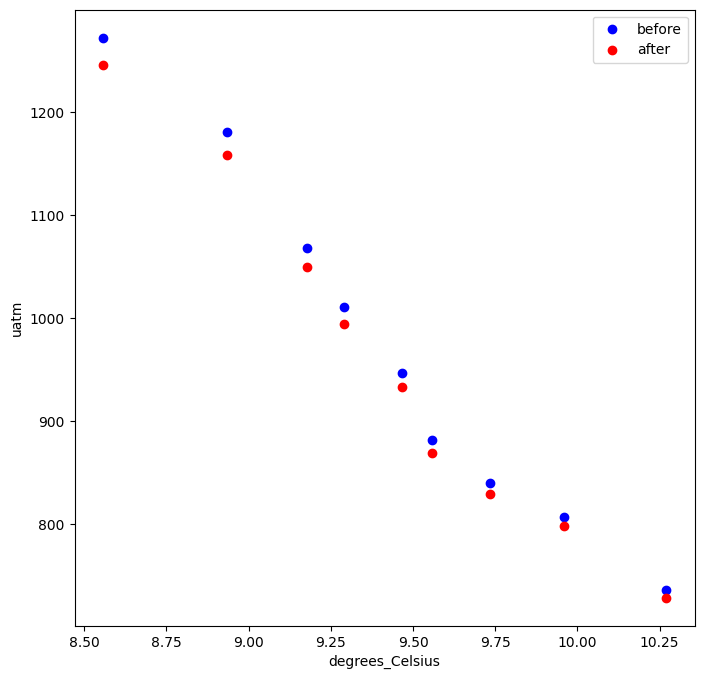

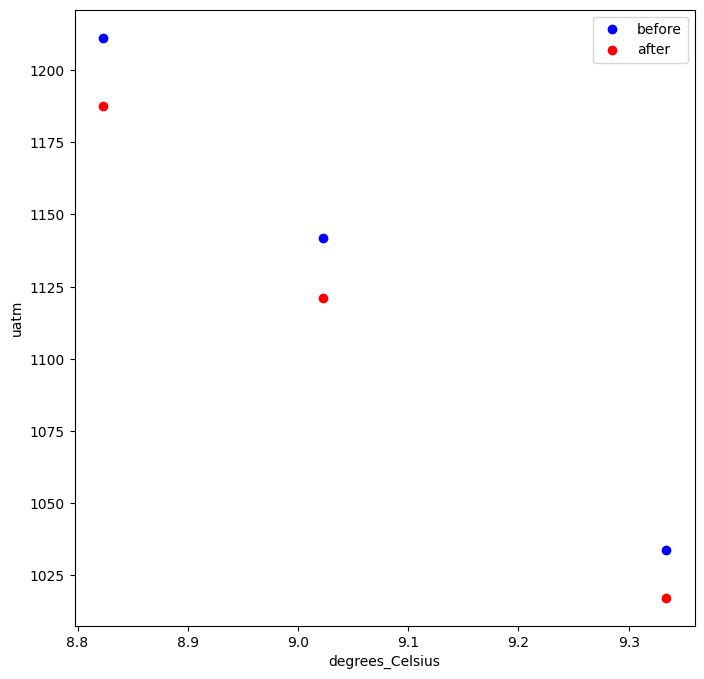

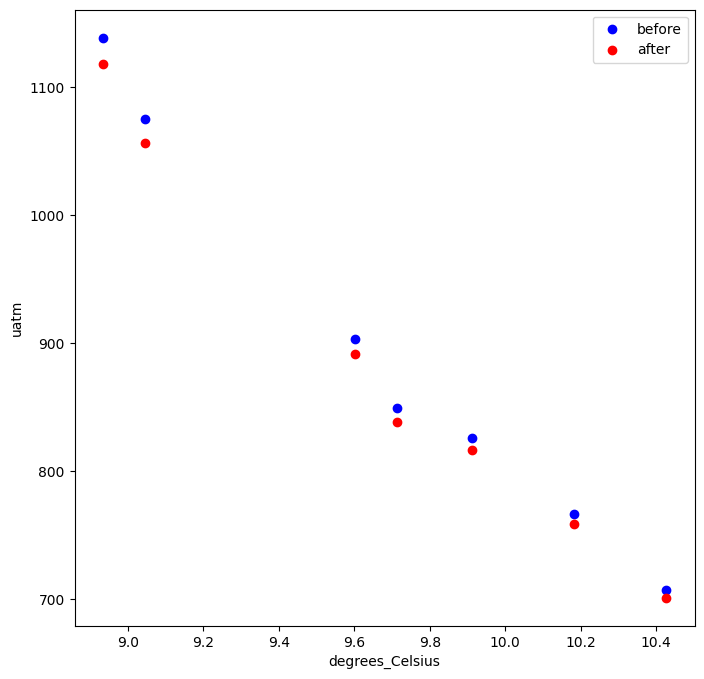

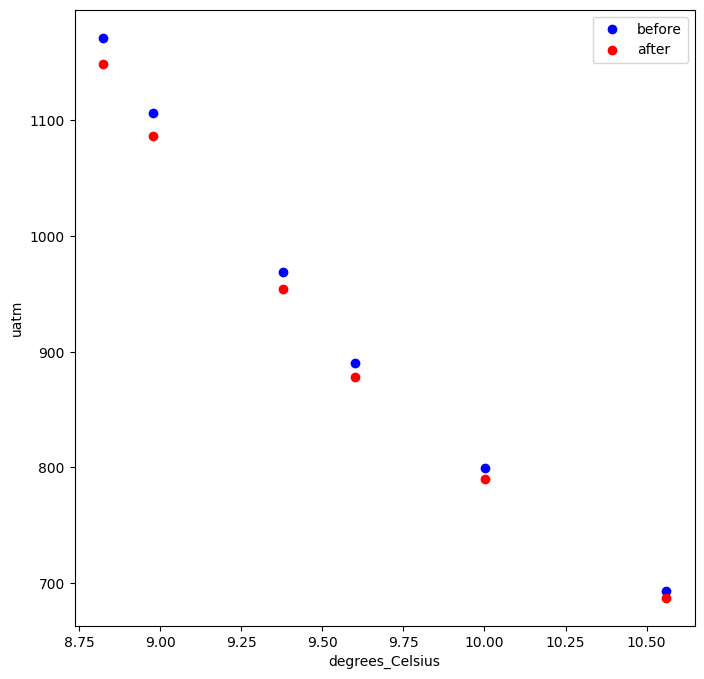

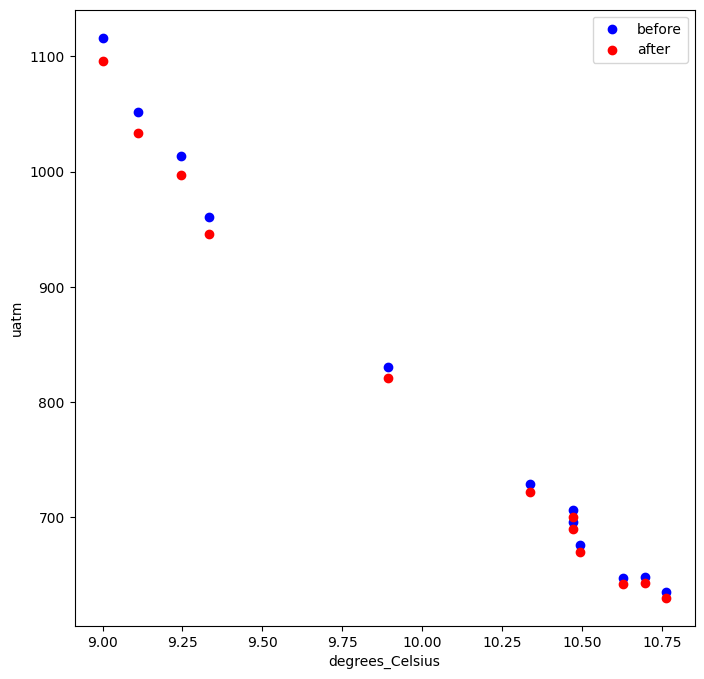

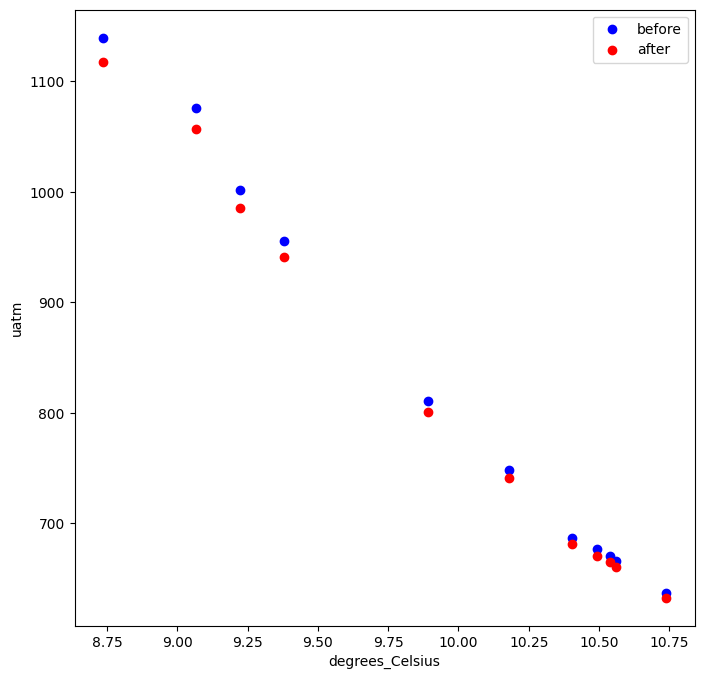

In [230]:
plot_profiles(indices_102, res_dict["CE04OSPS-SF01B-4F-PCO2WA102-streamed-pco2w_a_sami_data_record"])